## Phân tích xu hướng sở thích âm nhạc

#### Import các thư viện và các package cần thiết

In [59]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from matplotlib.figure import Figure 
from wordcloud import WordCloud

#### Load dữ liệu

In [60]:
df_normal  = pd.read_csv('list_info_03.csv') # Load các thông tin các video về âm nhạc thường
# df = pd.read_csv('list_info_trending.csv') # Load thông tin các video về âm nhạc trending
df_normal.head()


,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,NaN,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,NaN,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,NaN,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,NaN,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,NaN,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,NaN,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,NaN,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [61]:
# Xem thông tin tổng quan về data frame
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4962 non-null   object 
 1   publishAt             4962 non-null   object 
 2   title                 4962 non-null   object 
 3   description           4783 non-null   object 
 4   channelTitle          4962 non-null   object 
 5   tags                  4322 non-null   object 
 6   categoryId            4962 non-null   int64  
 7   defaultAudioLanguage  2776 non-null   object 
 8   duration              4962 non-null   object 
 9   dimension             4962 non-null   object 
 10  definition            4962 non-null   object 
 11  caption               4962 non-null   bool   
 12  privacyStatus         4962 non-null   object 
 13  embeddable            4962 non-null   bool   
 14  madeForKids           4962 non-null   bool   
 15  viewCount            

In [62]:
# Lọc ra các video âm nhạc tức categoryId là 10 - Music
df_normal = df_normal[df_normal['categoryId']==10]

In [63]:
# Xử lý các giá trị null trong data frame
df_normal_preprocessed = df_normal.fillna({'description':'', 'tags':'', 'defaultAudioLanguage':'', 'likeCount':0, 'dislikeCount':0, 'commentCount':0, 'topicCategories':'' })
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,0.0,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,0.0,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,0.0,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,0.0,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,0.0,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [64]:
# Mô tả các thuộc tính có giá trị nguyên
df_normal.describe()

,categoryId,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
count,3250.0,3.250000e+03,2.742000e+03,0.0,3250.0,3.212000e+03
mean,10.0,7.757448e+06,1.767001e+05,NaN,0.0,1.735291e+04
std,0.0,4.465801e+07,8.834424e+05,NaN,0.0,2.045653e+05
min,10.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00
25%,10.0,7.630100e+04,1.056250e+03,NaN,0.0,2.100000e+01
50%,10.0,3.032205e+05,4.079500e+03,NaN,0.0,9.400000e+01
75%,10.0,1.666436e+06,3.117650e+04,NaN,0.0,6.162500e+02
max,10.0,1.201917e+09,2.083092e+07,NaN,0.0,8.776885e+06


In [65]:
# Vẽ biểu đồ tròn thống kê theo số view của các video
def pieCharViewCounts(df):
    listVideo_10KView = df[df['viewCount']<100000]['id']
    listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
    listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
    listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
    listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']

    y = np.array([len(listVideo_10KView),
                    len(listVideo_100KView),
                    len(listVideo_1MView),
                    len(listVideo_10MView),
                    len(listVideo_100MView),
                ])
    mylabel = ['Video chuc nghin view', 'Video tram nghin view', 'Video trieu view', 'Video chuc trieu view', 'Video tram trieu view']
   
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.pie(y, labels=mylabel)
    plt.show()

/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


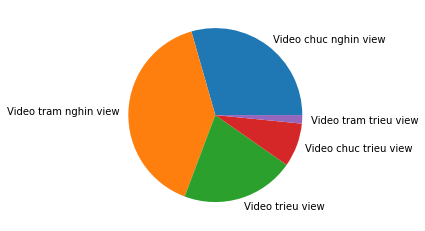

In [66]:
pieCharViewCounts(df_normal)

#### Xử lý tag và tên channel (thêm "_" vào các tag)


In [67]:
df_normal_preprocessed['tags'].fillna('', inplace=True)

In [68]:
def removeSpace(listItems, noise):
    tagsPreprocessed = []
    for item in listItems:
        if item == noise:
            tagsPreprocessed.append(item)
            continue
        item = item.replace(' ','_')
        item = item.replace(',_',', ')
        tagsPreprocessed.append(item)
    # print(tagsPreprocessed)
    return tagsPreprocessed

In [69]:
print(df_normal_preprocessed['tags'])
tagsPreprocessed = removeSpace(df_normal_preprocessed['tags'], ' ')
# df_normal_preprocessed.drop(columns=['tags'])
# df_normal_preprocessed.assign(tags = tagsPreprocessed)
# print(df_normal_preprocessed['tags'])
# print(tagsPreprocessed)
df_normal_preprocessed['tags'] = tagsPreprocessed

0       ['nhac remix', 'nhạc remix', 'nhạc remix nghe ...
1       ['nhu mot nguoi dung', 'như một người dưng', '...
2       ['DraTelling', 'Dra Telling', 'dratelling', 'd...
3                                                        
4       ['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...
                              ...                        
4956    ['Michael Bublé', 'Michael Buble', 'WBR', 'War...
4957    ['Nation Boss', 'Yaksta', 'Emotions', 'Trouble...
4958    ['Violette Wautier', 'V Violette', 'The Voice ...
4959    ['เพลงลูกทุ่ง', 'แกรมมี่ โกลด์', 'grammy gold'...
4960    ['J balvin', 'jbalvin new song', 'sech', 'una ...
Name: tags, Length: 3250, dtype: object


#### Xử lý topic categories

In [70]:
df_normal_preprocessed['topicCategories'] = df_normal['topicCategories'].fillna('')

In [71]:
listTopics=[]
for index, row in df_normal_preprocessed.iterrows():
    listTopic = row['topicCategories']
    if listTopic == '':
        listTopics.append(listTopic)
        continue
    topicStr = ''
    listTopic = listTopic.replace('https://en.wikipedia.org/wiki/','')
    listTopic = listTopic.replace("'Music'",'')
    listTopic = listTopic.replace(',','')
    listTopic = listTopic.replace('[','')
    listTopic = listTopic.replace(']','')
    listTopic = listTopic.replace('\'','')
    print(listTopic)
    listTopics.append(listTopic)
    #     #topic = topic.removesuffix("https://en.wikipedia.org/wiki/")
    #     print(topic)

print(type(listTopics))

Electronic_music Hip_hop_music  Pop_music
 Rhythm_and_blues Soul_music
Hip_hop_music 

 Pop_music
 Music_of_Asia

Hip_hop_music 
 Music_of_Asia Pop_music
Hip_hop_music 
 Music_of_Asia




Entertainment

 Music_of_Asia Pop_music
Knowledge

Knowledge

Knowledge
 Music_of_Asia Pop_music
Knowledge




Knowledge


 Music_of_Asia Pop_music
Entertainment Television_program



Electronic_music 
Entertainment Music_of_Asia Television_program

 Music_of_Asia Pop_music
 Pop_music
 Pop_music
Entertainment Music_of_Asia Television_program
Entertainment Television_program
 Music_of_Asia Pop_music
 Music_of_Asia
 Pop_music

 Music_of_Asia
Christian_music 

Hip_hop_music 

Christian_music 
Electronic_music 

 Music_of_Asia



 Pop_music

 Music_of_Asia
 Pop_music
Hip_hop_music  Music_of_Asia Pop_music
 Music_of_Asia
Entertainment Television_program
 Pop_music

 Music_of_Asia
 Pop_music


Electronic_music 




 Pop_music




 Music_of_Asia
Entertainment
 Pop_music

 Music_of_Asia Pop_music

 Music_of_A

In [72]:
df_normal_preprocessed['topicCategories'] = listTopics
df_normal_preprocessed

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,0.0,0,5372.0,Electronic_music Hip_hop_music Pop_music
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,0.0,0,11.0,Rhythm_and_blues Soul_music
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,0.0,0,8832.0,Hip_hop_music
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,0.0,0,93.0,
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,0.0,0,12.0,Pop_music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,Mk6ZzzWWJ1A,2021-10-15T13:00:20Z,Michael Bublé - Let It Snow! [10th Anniversary...,"The Official Music Video for Michael Bublé's ""...",Michael Bublé,"['Michael_Bublé', 'Michael_Buble', 'WBR', 'War...",10,,PT2M53S,2d,...,False,public,True,False,4724387,42123.0,0.0,0,965.0,Christian_music
4957,ekzPebnuEls,2021-06-08T16:15:12Z,Nation Boss & Yaksta - Emotions (Official Musi...,Nation Boss & Yaksta - Emotions (prod by Troub...,Nation Boss Official,"['Nation_Boss', 'Yaksta', 'Emotions', 'Trouble...",10,en,PT3M29S,2d,...,False,public,True,False,2438926,68810.0,0.0,0,4001.0,Hip_hop_music Reggae
4958,5AJOOGuGn5U,2021-05-24T12:00:15Z,Violette Wautier - กักตัว (Official Music Video),Violette Wautier - กักตัว (Official Music Vide...,Violette Wautier,"['Violette_Wautier', 'V_Violette', 'The_Voice_...",10,en,PT4M2S,2d,...,True,public,True,False,5229516,87646.0,0.0,0,2776.0,Pop_music
4959,tnkPPRhfRvE,2021-11-04T06:00:25Z,ไม่เคย(เพลงประกอบภาพยนตร์ ส้มป่อย) - ไม้เมือง ...,เพลง : ไม่เคย(เพลงประกอบภาพยนตร์ ส้มป่อย)\nศิล...,GRAMMY GOLD OFFICIAL,"['เพลงลูกทุ่ง', 'แกรมมี่_โกลด์', 'grammy_gold'...",10,th,PT3M2S,2d,...,False,public,True,False,1351117,19096.0,0.0,0,609.0,Music_of_Asia


#### Xử lý thời gian 

In [73]:
def convertHour(str):
    if str.find('H') == -1:
        return 0
    hour = str.split('T')[1].split('H')[0]
    return hour

def convertMinute(str):
    if str.find('M') == -1:
        return 0
    if str.find('H') != -1:
        minute = str.split('H')[1].split('M')[0]
    else:
        minute = str.split('T')[1].split('M')[0]
    return minute

def convertSecond(str):
    if str.find('S') == -1:
        return 0
    if str.find('M') == -1:
        if str.find('H') == -1:
            second = str.split('T')[1].split('S')[0]
        else:    
            second = str.split('H')[1].split('S')[0]
    else:
        second = str.split('M')[1].split('S')[0]
    return second

In [74]:
hours, minutes, seconds = [], [], []
years, months, days = [], [], []
durationInt = []
for index, row in df_normal.iterrows():
    hours.append(int(convertHour(row['duration'])))
    minutes.append(int(convertMinute(row['duration'])))
    seconds.append(int(convertSecond(row['duration'])))
    years.append(int(row['publishAt'].split('-',1)[0]))
    months.append(int(row['publishAt'].split('-',1)[1].split('-',1)[0]))
    days.append(int(row['publishAt'].split('-',2)[2].split('T')[0]))
    durationInt.append(hours[-1]*60*60+minutes[-1]*60+seconds[-1])

In [75]:
df_normal_preprocessed = df_normal_preprocessed.assign(hourDuration=hours, minuteDuration=minutes, secondDuration=seconds, yearPublished=years, monthPublished=months, dayPublished=days, durationInt = durationInt)
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,favoriteCount,commentCount,topicCategories,hourDuration,minuteDuration,secondDuration,yearPublished,monthPublished,dayPublished,durationInt
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,0,5372.0,Electronic_music Hip_hop_music Pop_music,0,57,27,2021,2,5,3447
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,0,11.0,Rhythm_and_blues Soul_music,1,9,43,2021,12,7,4183
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,0,8832.0,Hip_hop_music,0,4,4,2021,11,27,244
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,0,93.0,,0,7,30,2021,12,7,450
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,0,12.0,Pop_music,2,13,13,2021,11,14,7993


#### Xử lý tên video 

In [76]:
# Hàm xóa bỏ một số từ gây nhiễu
def removeStopword(texts, stopwords):
    tmpList = []
    for text in texts:
        text = text.lower()
        for stopword in stopwords:
            text = text.replace(stopword,'')
        tmpList.append(text)
    return tmpList

#### Xử lý giá trị các cột về số nguyên

In [77]:
le_captions = preprocessing.LabelEncoder()
le_captions.fit(df_normal['caption'])
df_normal_preprocessed['caption'] = le_captions.transform(df_normal['caption'])

le_embeddables = preprocessing.LabelEncoder()
le_embeddables.fit(df_normal['embeddable'])
df_normal_preprocessed['embeddable'] = le_embeddables.transform(df_normal['embeddable'])

le_madeForKids = preprocessing.LabelEncoder()
le_madeForKids.fit(df_normal['madeForKids'])
df_normal_preprocessed['madeForKids'] = le_madeForKids.transform(df_normal['madeForKids'])

le_privacyStatus = preprocessing.LabelEncoder()
le_privacyStatus.fit(df_normal['privacyStatus'])
df_normal_preprocessed['privacyStatus'] = le_privacyStatus.transform(df_normal['privacyStatus'])

le_definitions = preprocessing.LabelEncoder()
le_definitions.fit(df_normal['definition'])
df_normal_preprocessed['definition'] = le_definitions.transform(df_normal['definition'])

In [78]:
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,favoriteCount,commentCount,topicCategories,hourDuration,minuteDuration,secondDuration,yearPublished,monthPublished,dayPublished,durationInt
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,0,5372.0,Electronic_music Hip_hop_music Pop_music,0,57,27,2021,2,5,3447
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,0,11.0,Rhythm_and_blues Soul_music,1,9,43,2021,12,7,4183
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,0,8832.0,Hip_hop_music,0,4,4,2021,11,27,244
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,0,93.0,,0,7,30,2021,12,7,450
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,0,12.0,Pop_music,2,13,13,2021,11,14,7993


#### Phân tích một số mối quan hệ 

##### Phân phối các video theo số view, like

(array([2.688e+03, 3.000e+01, 1.400e+01, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([       0. ,  2083092.5,  4166185. ,  6249277.5,  8332370. ,
        10415462.5, 12498555. , 14581647.5, 16664740. , 18747832.5,
        20830925. ]),
 <BarContainer object of 10 artists>)

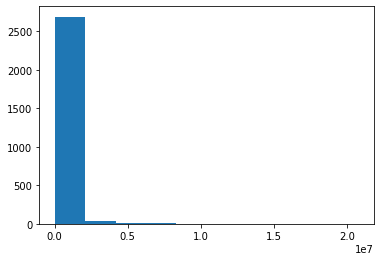

In [79]:
plt.hist(df_normal['likeCount'])

(array([1758.,  186.,  103.,   58.,   61.,   36.,   37.,   32.,   19.,
          20.]),
 array([    0. ,  9994.1, 19988.2, 29982.3, 39976.4, 49970.5, 59964.6,
        69958.7, 79952.8, 89946.9, 99941. ]),
 <BarContainer object of 10 artists>)

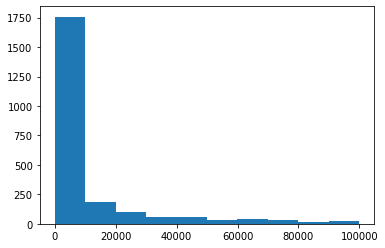

In [80]:
plt.hist(df_normal[df_normal['likeCount']<1e5]['likeCount'])

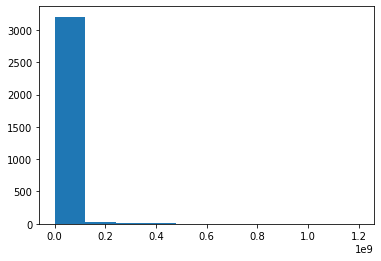

In [81]:
plt.hist(df_normal['viewCount']);

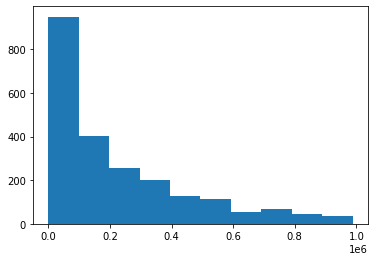

In [82]:
plt.hist(df_normal[df_normal['viewCount']<1e6]['viewCount']);

(array([3.09e+03, 1.09e+02, 6.00e+00, 4.00e+00, 5.00e+00, 1.00e+00,
        4.00e+00, 3.00e+00, 3.00e+00, 2.50e+01]),
 array([    0. ,  8637.9, 17275.8, 25913.7, 34551.6, 43189.5, 51827.4,
        60465.3, 69103.2, 77741.1, 86379. ]),
 <BarContainer object of 10 artists>)

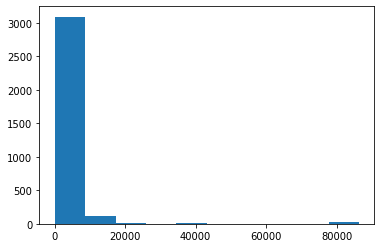

In [83]:
plt.hist(df_normal_preprocessed['durationInt'])

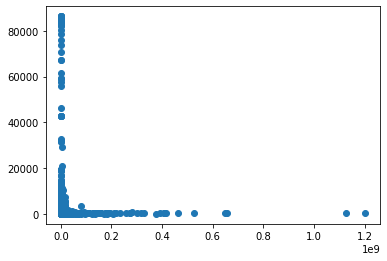

In [84]:
plt.scatter(df_normal_preprocessed['viewCount'], df_normal_preprocessed['durationInt'])

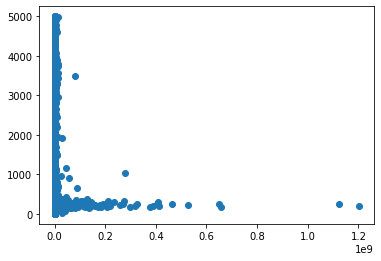

In [85]:
plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['durationInt'])

/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1613510240.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])


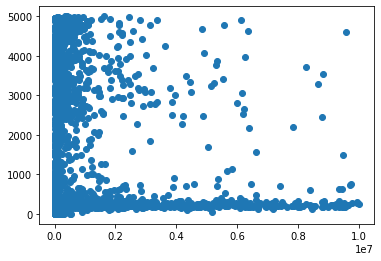

In [86]:

plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])

##### Quan hệ giữa các thuộc tính

In [87]:
corr = df_normal_preprocessed.corr()
print(df_normal_preprocessed.head(5))

            id             publishAt  \
0  suZ-c2q3joo  2021-02-05T00:32:42Z   
1  z9cON_B1NVw  2021-12-07T08:00:39Z   
2  JRRL0sBzuKE  2021-11-27T12:30:15Z   
3  wluTO6iyGYw  2021-12-07T12:07:03Z   
4  BnTZ0gVGrnQ  2021-11-14T02:00:02Z   

                                               title  \
0  Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...   
1  TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...   
2  Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...   
3                                   Âm Nhạc Thư Giãn   
4  Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...   

                                         description        channelTitle  \
0  Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...  HOA HỒNG DẠI MUSIC   
1  TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...            Tình Đầu   
2  Nhạc này hay dã man nhể loài người?\nTất nhiên...          DraTelling   
3  ✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...       Tiểu Vũ - 小宇    
4  Tuyển Tập Nhạc Việt Hay Nhất Từng Gây B

In [88]:
df_normal_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int64  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int64  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

<AxesSubplot:>

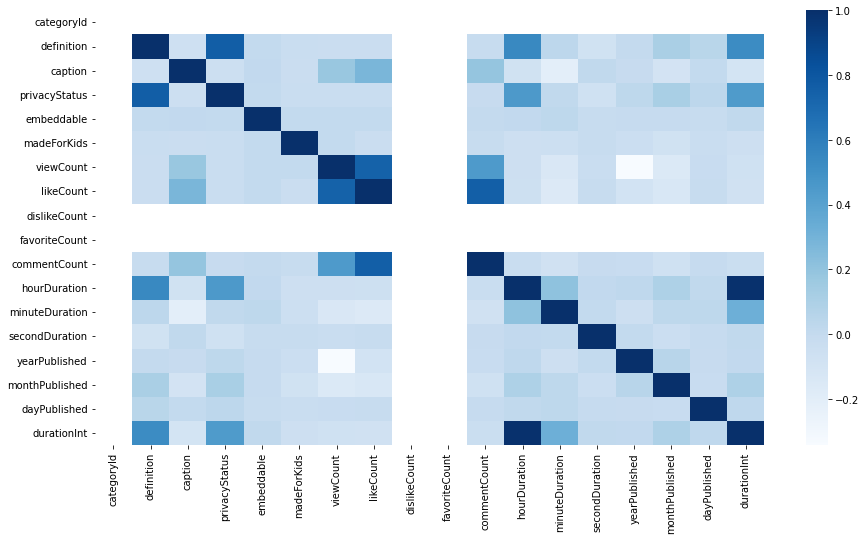

In [89]:
plt.figure(figsize=(15,8))
heatmap_df_normal_preprocess = df_normal_preprocessed[['viewCount','likeCount','dislikeCount','commentCount', 'favoriteCount']]
corr = df_normal_preprocessed.corr()
sns.heatmap(corr, cmap='Blues')

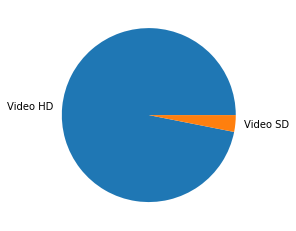

In [90]:
# plt.figure(figsize=(8,16))

# plt.scatter(df_normal_preprocessed['definition'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

hd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
sd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([hd_videos.shape[0], sd_videos.shape[0]])
mylabel = ['Video HD', 'Video SD']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

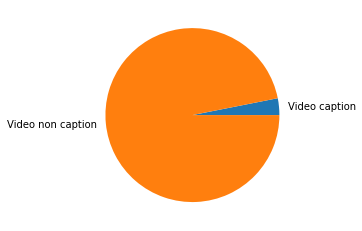

In [91]:
# plt.scatter(df_normal_preprocessed['caption'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Caption')
# plt.xlabel('Caption')
# plt.ylabel('View count')

df_normal['caption'].unique()

caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([caption_videos.shape[0], non_caption_videos.shape[0]])
mylabel = ['Video caption', 'Video non caption']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

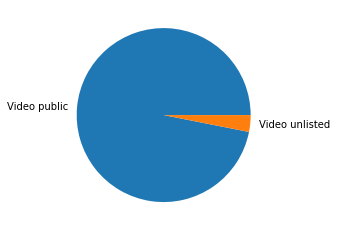

In [92]:
# plt.scatter(df_normal_preprocessed['privacyStatus'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

df_normal['privacyStatus'].unique()

public_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
unlisted_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([public_videos.shape[0], unlisted_videos.shape[0]])
mylabel = ['Video public', 'Video unlisted']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

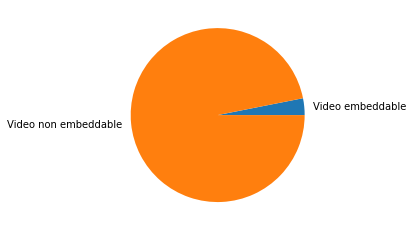

In [93]:
# plt.scatter(df_normal_preprocessed['embeddable'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['embeddable'].unique()

embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([embeddable_videos.shape[0], non_embeddable_videos.shape[0]])
mylabel = ['Video embeddable', 'Video non embeddable']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

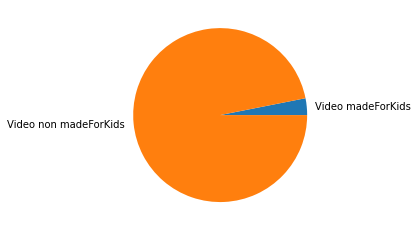

In [94]:
# plt.scatter(df_normal_preprocessed['madeForKids'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['madeForKids'].unique()
# test = df_normal[df_normal['madeForKids']==False]
madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([madeForKids_videos.shape[0], non_madeForKids_videos.shape[0]])
mylabel = ['Video madeForKids', 'Video non madeForKids']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

#### Chuyển text thành vector IF TDF

In [95]:
def convertIfTdf(df, column, stopwords):
    data_train = df[column]
    data_train = removeStopword(data_train, stopwords)

    module_count_vector = TfidfVectorizer(stop_words=stopwords)
    model_rf_preprocess = Pipeline([('vect', module_count_vector),
                        ('tfidf', TfidfTransformer()),
                        ])
    # Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
    # Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
    data_preprocessed = module_count_vector.fit_transform(data_train)

    print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
    print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
    print(f"Xem các từ trong từ điển: {module_count_vector.vocabulary_}")
    print(type(data_preprocessed))
    return data_preprocessed


In [96]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X = convertIfTdf(df_normal_preprocessed,'title', stopwords)
print(type(X))


Số lượng từ trong từ điển: 4366
Kích thước dữ liệu sau khi xử lý: (3250, 4366)
Xem các từ trong từ điển: {'top': 3522, '15': 32, 'remix': 2890, 'nghe': 2334, 'nhiều': 2410, 'nhất': 2433, 'kẹo': 1796, 'bông': 528, 'gòn': 1327, 'đường': 4156, 'quyền': 2820, 'tình': 3667, 'yêu': 4036, 'em': 1074, 'băng': 532, 'qua': 2802, 'níu': 2523, 'duyên': 1004, 'đang': 4087, 'gây': 1324, 'bão': 513, 'trên': 3575, 'các': 781, 'bxh': 499, 'như': 2428, 'một': 2282, 'người': 2377, 'dưng': 1029, 'lạ': 1977, 'thoáng': 3383, 'họa': 1509, 'ức': 4304, 'dratellingmontee': 975, 'prod': 2781, 'tuanuki': 3621, 'animate': 277, 'sino': 3119, 'thư': 3431, 'giãn': 1256, 'việt': 3812, 'hay': 1368, 'từng': 3730, 'bảng': 542, 'xếp': 3994, 'hạng': 1491, 'khúc': 1709, 'trẻ': 3604, 'tôi': 3675, 'season': 3033, 'nửa': 2561, 'hồn': 1515, 'thương': 3432, 'đau': 4088, 'thanh': 3358, 'lan': 1820, 'liveshow': 1882, 'hải': 1499, 'ngoại': 2354, 'trúc': 3584, 'sinh': 3115, 'entertainment': 1087, '60s': 142, 'búp': 531, 'bê': 518, 

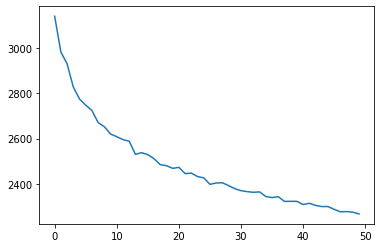

In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
loss = []
for i in range(50):
    i = i + 1
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    loss.append(kmeans.inertia_)
plt.plot(range(50), loss)

In [98]:
clustering = KMeans(n_clusters=10,init='k-means++', random_state=0).fit(X)
clustering.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00209965, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [99]:
label = clustering.labels_
print(label.shape)
for i in label:
    print(i)

(3250,)
5
6
6
6
3
6
6
6
6
6
6
6
8
6
6
6
6
6
6
6
6
6
6
5
6
6
6
6
6
6
6
6
8
6
6
6
6
5
6
6
6
3
6
6
6
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
3
6
6
6
5
8
8
6
6
5
6
6
8
6
6
6
6
8
6
3
6
6
6
8
6
6
6
8
8
3
6
6
3
6
6
6
6
8
6
8
6
6
6
6
6
6
6
6
1
1
1
1
6
1
5
6
1
5
9
5
5
5
7
4
1
5
1
1
1
6
1
6
5
1
2
5
4
1
4
5
4
1
1
1
1
6
1
5
5
9
5
6
7
6
6
1
7
6
6
1
5
7
8
6
6
6
6
2
6
1
5
1
6
6
1
6
1
1
6
1
6
7
6
9
2
1
4
5
6
8
6
6
1
2
8
5
1
6
6
1
6
6
1
1
6
6
6
1
4
8
6
6
8
1
9
8
6
1
1
6
5
6
6
6
5
6
6
7
4
5
6
6
1
2
8
6
6
1
6
1
1
5
5
2
6
7
6
5
6
5
8
8
6
6
2
6
6
6
1
6
6
1
1
8
6
1
6
1
6
6
5
6
5
5
1
1
6
6
6
8
1
6
6
6
6
6
8
6
5
5
6
6
1
6
6
1
6
1
1
6
6
1
6
1
6
6
5
6
6
6
1
5
6
1
8
6
5
6
6
1
6
1
6
8
6
6
8
8
6
6
8
6
6
1
6
8
6
6
6
6
1
1
6
6
1
6
1
6
1
6
1
1
8
6
8
6
6
1
8
8
8
6
8
8
1
8
8
6
6
6
6
8
8
6
6
8
8
8
8
6
6
8
8
6
6
8
5
6
6
6
8
6
6
6
8
8
8
8
6
6
8
8
8
6
6
6
6
6
6
6
6
6
6
6
6
6
0
2
2
0
0
5
0
6
0
0
0
0
6
5
6
0
6
5
0
0
0
0
0
0
5
0
4
0
4
4
0
0
0
4
9
0
6
0
6
0
2
4
0
4
4
4
0
0
4
4
0
0
4
0
4
0
0
9
0
2
4
0
0
5
5
9
9
0
0


In [100]:
temp_df = df_normal_preprocessed.assign(label=label)
temp_df = temp_df.assign(topics = listTopics)
temp_df.info()

for i in range(len(np.unique(label))):
    print(i)
    filter_df = temp_df[label==i]
    filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int64  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int64  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

In [101]:
def drawWordCloud(df, column, stopwords):
  for i in range(len(np.unique(label))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()



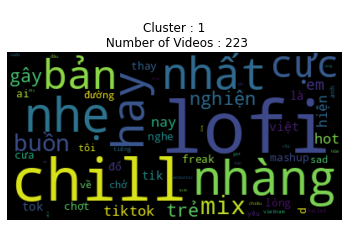

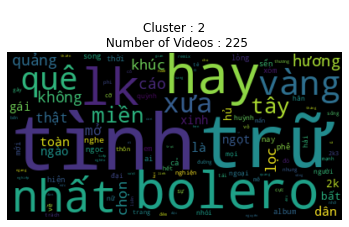

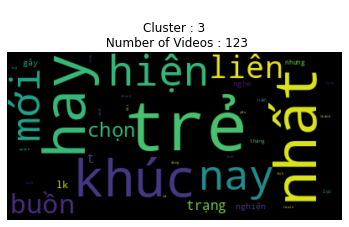

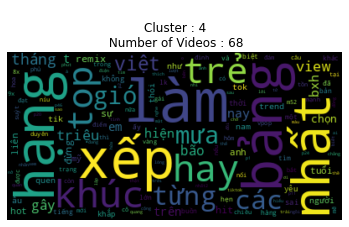

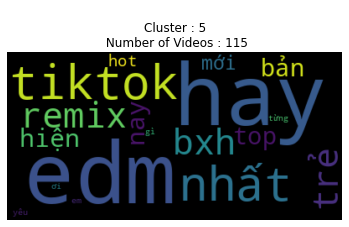

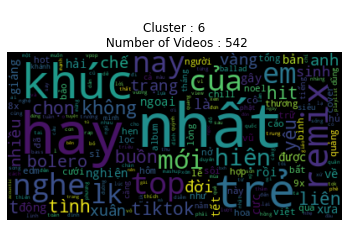

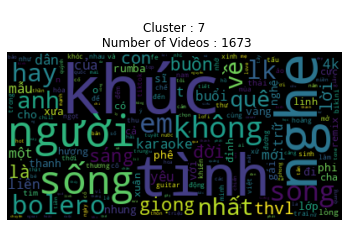

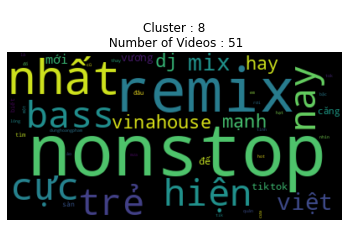

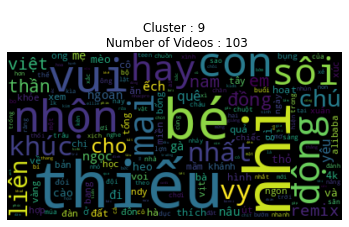

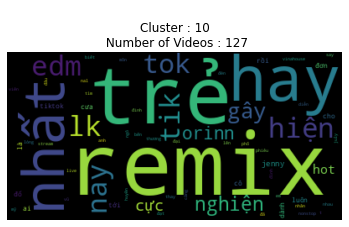

In [102]:
drawWordCloud(temp_df,'title', stopwords)

0


/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


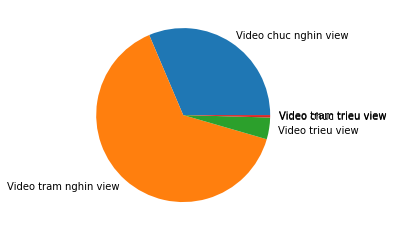

1


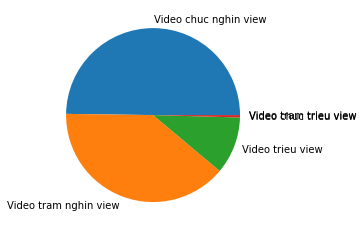

2


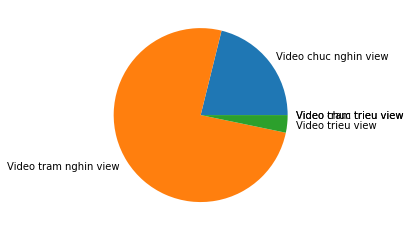

3


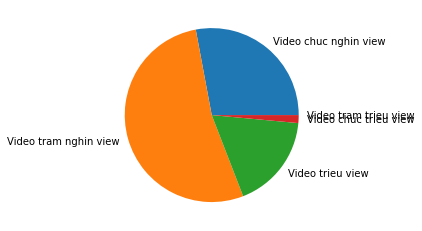

4


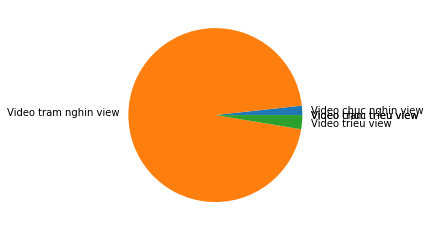

5


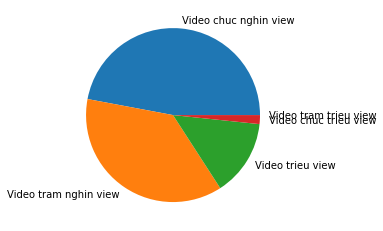

6


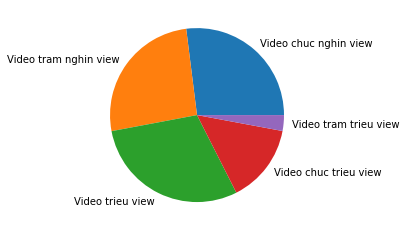

7


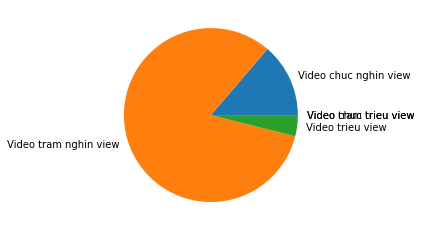

8


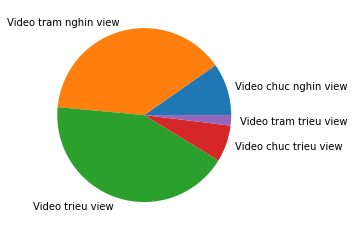

9


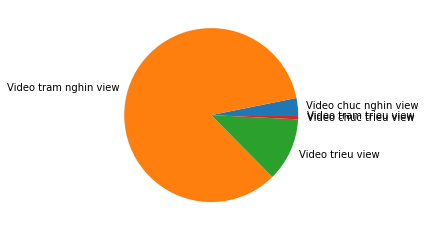

In [103]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(temp_df[temp_df['label']==i])

In [104]:
clustered_df = temp_df.groupby(['label']).sum()

In [105]:
clustered_df[['viewCount', 'likeCount', 'durationInt']]

,viewCount,likeCount,durationInt
label,,,
0,89230736,515148.0,724423
1,118550098,2384239.0,2447635
2,41940541,232354.0,746225
3,53205338,155784.0,461525
4,51183052,447746.0,583905
5,429444263,2714349.0,3205259
6,23534411417,475847929.0,3167148
7,19900713,154324.0,223874
8,782986636,1703104.0,148220


In [106]:
abnormal_cluster = temp_df[temp_df['label']==6]
# abnormal_cluster = abnormal_cluster[abnormal_cluster['label']==2]

In [107]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X_abnormal = convertIfTdf(abnormal_cluster,'title', stopwords)
print(type(X_abnormal))
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=0).fit(X_abnormal)
kmeans.cluster_centers_

label = kmeans.labels_

print(label.shape)
for i in label:
    print(i)
abnormal_cluster = abnormal_cluster.assign(label = label)


Số lượng từ trong từ điển: 3994
Kích thước dữ liệu sau khi xử lý: (1673, 3994)
Xem các từ trong từ điển: {'top': 3220, 'đang': 3732, 'gây': 1185, 'bão': 414, 'trên': 3269, 'các': 660, 'bxh': 400, 'như': 2219, 'một': 2088, 'người': 2177, 'dưng': 900, 'lạ': 1803, 'thoáng': 3090, 'qua': 2542, 'họa': 1359, 'ức': 3932, 'dratellingmontee': 849, 'prod': 2521, 'tuanuki': 3311, 'animate': 187, 'sino': 2840, 'thư': 3133, 'giãn': 1119, 'tôi': 3362, 'season': 2756, 'nửa': 2319, 'hồn': 1365, 'thương': 3134, 'đau': 3733, 'thanh': 3066, 'lan': 1654, 'liveshow': 1716, 'hải': 1349, 'ngoại': 2156, 'trúc': 3277, 'sinh': 2836, 'entertainment': 952, '60s': 86, 'búp': 431, 'bê': 419, 'trò': 3273, 'chơi': 546, 'con': 606, 'mực': 2094, 'squid': 2911, 'game': 1076, 'nhảy': 2222, 'cực': 718, 'sung': 2954, 'cùng': 678, 'trai': 3232, 'đẹp': 3814, 'rise': 2648, 'above': 122, 'tripledmai': 3247, 'mr': 2017, 'vịt': 3546, 'yomost': 3680, 'vfl': 3464, 'winter': 3604, '2021': 45, 'theme': 3072, 'song': 2881, 'vũ': 352

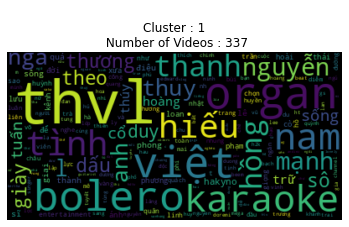

{'thvl': 1.0, 'organ': 0.4888888888888889, 'việt': 0.4444444444444444, 'bolero': 0.4222222222222222, 'karaoke': 0.35555555555555557, 'nam': 0.35555555555555557, 'tình': 0.3111111111111111, 'hiếu': 0.28888888888888886, 'hồng': 0.2222222222222222, 'thanh': 0.2222222222222222, 'nguyễn': 0.2, 'mạnh': 0.2, 'anh': 0.17777777777777778, 'thuy': 0.17777777777777778, 'nga': 0.17777777777777778, 'l': 0.17777777777777778, 'thương': 0.17777777777777778, 'theo': 0.17777777777777778, 'dấu': 0.17777777777777778, 'giày': 0.17777777777777778, 'sô': 0.17777777777777778, 'duy': 0.17777777777777778, 'sống': 0.15555555555555556, 'tuấn': 0.15555555555555556, 'cổ': 0.15555555555555556, 'hoàng': 0.15555555555555556, 'trữ': 0.15555555555555556, 'thúy': 0.15555555555555556, 'hakyno': 0.15555555555555556, 'sĩ': 0.13333333333333333, 'giai': 0.13333333333333333, 'điệu': 0.13333333333333333, 'sông': 0.13333333333333333, 'phong': 0.13333333333333333, 'quá': 0.13333333333333333, 'lê': 0.13333333333333333, 'thành': 0.1

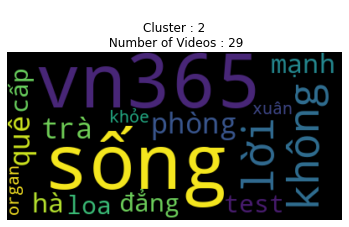

{'sống': 1.0, 'vn365': 0.9565217391304348, 'không': 0.13043478260869565, 'lời': 0.13043478260869565, 'phòng': 0.043478260869565216, 'trà': 0.043478260869565216, 'quê': 0.043478260869565216, 'mạnh': 0.043478260869565216, 'hà': 0.043478260869565216, 'đẳng': 0.043478260869565216, 'cấp': 0.043478260869565216, 'test': 0.043478260869565216, 'loa': 0.043478260869565216, 'xuân': 0.043478260869565216, 'khỏe': 0.043478260869565216, 'organ': 0.043478260869565216}


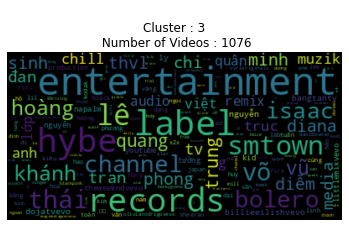

{'entertainment': 1.0, 'label': 0.7692307692307693, 'hybe': 0.7435897435897436, 'records': 0.717948717948718, 'lê': 0.5384615384615384, 'smtown': 0.48717948717948717, 'thái': 0.4358974358974359, 'võ': 0.41025641025641024, 'channel': 0.38461538461538464, 'bolero': 0.38461538461538464, 'isaac': 0.358974358974359, 'khánh': 0.3076923076923077, 'hoàng': 0.3076923076923077, 'vũ': 0.2564102564102564, 'trung': 0.20512820512820512, 'quang': 0.20512820512820512, 'sinh': 0.1794871794871795, 'diễm': 0.1794871794871795, 'minh': 0.1794871794871795, 'thvl': 0.1794871794871795, 'phong': 0.1794871794871795, 'diana': 0.1794871794871795, 'tv': 0.15384615384615385, 'chi': 0.15384615384615385, 'tran': 0.15384615384615385, 'đan': 0.15384615384615385, 'media': 0.15384615384615385, 'truc': 0.1282051282051282, 'chill': 0.1282051282051282, 'anh': 0.1282051282051282, 'g': 0.1282051282051282, 'muzik': 0.1282051282051282, 'lớp': 0.1282051282051282, 'audio': 0.1282051282051282, 'việt': 0.1282051282051282, 'remix': 

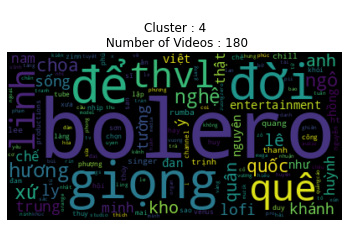

{'bolero': 1.0, 'giọng': 0.9310344827586207, 'để': 0.896551724137931, 'đời': 0.896551724137931, 'quê': 0.4827586206896552, 'thvl': 0.4482758620689655, 'linh': 0.41379310344827586, 'hương': 0.3448275862068966, 'xứ': 0.3103448275862069, 'nghệ': 0.3103448275862069, 'ngô': 0.27586206896551724, 'choa': 0.2413793103448276, 'quốc': 0.2413793103448276, 'lê': 0.20689655172413793, 'anh': 0.20689655172413793, 'kho': 0.20689655172413793, 'quân': 0.20689655172413793, 'khánh': 0.1724137931034483, 'trung': 0.1724137931034483, 'sống': 0.1724137931034483, 'lofi': 0.1724137931034483, 'ly': 0.1724137931034483, 'tường': 0.1724137931034483, 'nam': 0.13793103448275862, 'minh': 0.13793103448275862, 'ý': 0.13793103448275862, 'huỳnh': 0.13793103448275862, 'thật': 0.13793103448275862, 'chế': 0.13793103448275862, 'việt': 0.10344827586206896, 'đan': 0.10344827586206896, 'nguyên': 0.10344827586206896, 'hồng': 0.10344827586206896, 'entertainment': 0.10344827586206896, 'như': 0.10344827586206896, 'singer': 0.1034482

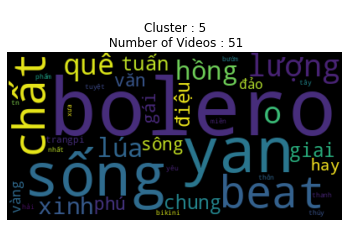

{'bolero': 1.0, 'yan': 0.56, 'sống': 0.52, 'beat': 0.24, 'chất': 0.24, 'lượng': 0.24, 'o': 0.24, 'quê': 0.2, 'hồng': 0.16, 'lúa': 0.16, 'xinh': 0.16, 'tuấn': 0.12, 'chung': 0.12, 'giai': 0.12, 'điệu': 0.12, 'sông': 0.12, 'văn': 0.12, 'phú': 0.12, 'gái': 0.12, 'hay': 0.12, 'đảo': 0.08, 'vàng': 0.08, 'trangpi': 0.08, 'bikini': 0.04, 'yêu': 0.04, 'miền': 0.04, 'tây': 0.04, 'tn': 0.04, 'thanh': 0.04, 'hải': 0.04, 'thôn': 0.04, 'nhất': 0.04, 'thúy': 0.04, 'xưa': 0.04, 'tuyệt': 0.04, 'phẩm': 0.04, 'bướm': 0.04}


In [108]:
for i in range(len(np.unique(label))):
    
    #Extract cleaned text column
    data=abnormal_cluster[abnormal_cluster['label']==i]['channelTitle'].values
    data = removeStopword(data, stopwords)
    list_of_words=[];
    for sent in data:
      if type(sent)!=str:
        continue
      for word in sent.split():
        list_of_words.append(word)  
    final_text=" ".join(list_of_words)
    wordcloud = WordCloud(collocations=False).generate(final_text)
    plt.figure()
    title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


0


/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
/var/folders/lv/hcn20sp51tz2bc1v6l7vdn200000gn/T/ipykernel_2183/1180833226.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


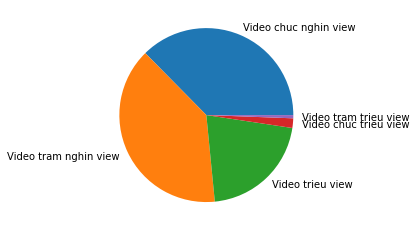

1


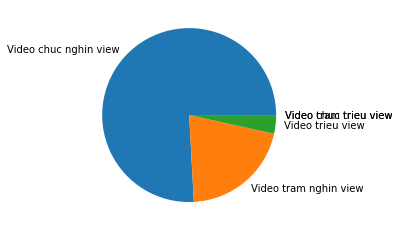

2


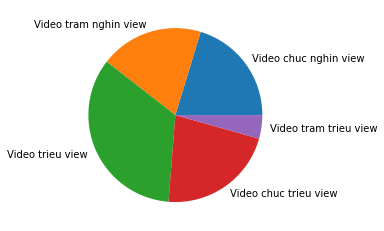

3


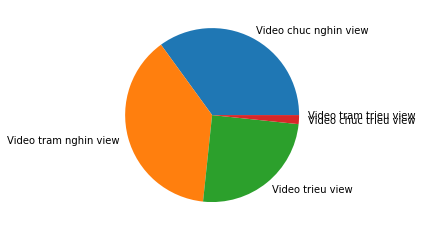

4


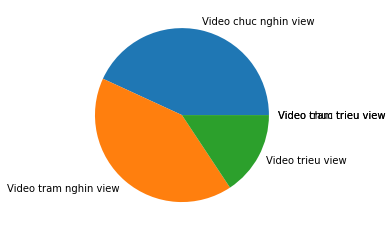

In [109]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(abnormal_cluster[abnormal_cluster['label']==i])

In [110]:
clustered_02_abnormal = abnormal_cluster[abnormal_cluster['label']!=2].sum()
clustered_02_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      994396138
likeCount      7257261.0
durationInt      2442637
dtype: object

In [111]:
clustered_01_abnormal = abnormal_cluster[abnormal_cluster['label']==2].sum()
clustered_01_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      22540015279
likeCount      468590668.0
durationInt         724511
dtype: object

In [112]:
for item in abnormal_cluster[abnormal_cluster['label']==0]['title']:
    print(item)

TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm Nhạc | Như Một Người Dưng, Người Lạ Thoáng qua
TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm Nhạc | Người Lạ Thoáng Qua, Hẹn Kiếp Sau
NAM EM PLAYLIST | NGƯỜI KỂ CHUYỆN TÌNH BẰNG ÂM NHẠC
ÂM NHẠC 6 - Những ước mơ KARAOKE - KẾT NỐI TRI THỨC
TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm Nhạc | Ai Chung Tình Được Mãi, Người Lạ Thoáng Qua
Lk Mẹ Hiền Quan Âm - Nhạc Phật Giáo Chọn Lọc 2021 Tĩnh Tâm Xua Tan Buồn Phiền
[HÁT MẪU] CHÀO NGƯỜI BẠN MỚI ĐẾN - ÂM NHẠC LỚP 1 KẾT NỐI TRI THỨC VỚI CUỘC SỐNG - PHẠM HOÀI LINH
Con Chim Non - Karaoke Âm Nhạc Lớp 3 | Lớp Nhạc Doremi
Giấc mơ trưa - Tùng Dương (liveshow Con đường âm nhạc)
SẮC MÀU ÂM NHẠC | THÁNG 10 - 2021 | NGƯỜI DÌU CON ĐI
[Âm Nhạc Xứ Nẫu] #03: Liên Khúc Nhạc Ngoại Lời Việt | MV Quay tại Phú Yên Camping Trip
HÀNH TRÌNH CỦA THANH ÂM | MỘT ĐÊM SAY | ANDIEZ - THỊNH SUY COVER
Những ước mơ KARAOKE | Âm nhạc lớp 6 | KẾT NỐI TRI THỨC
Con đường học trò KARAOKE | Âm nhạc lớp 6 | Kết nối tri thức.
Thanh Tu

In [113]:
print(wordcloud.words_)

{'bolero': 1.0, 'yan': 0.56, 'sống': 0.52, 'beat': 0.24, 'chất': 0.24, 'lượng': 0.24, 'o': 0.24, 'quê': 0.2, 'hồng': 0.16, 'lúa': 0.16, 'xinh': 0.16, 'tuấn': 0.12, 'chung': 0.12, 'giai': 0.12, 'điệu': 0.12, 'sông': 0.12, 'văn': 0.12, 'phú': 0.12, 'gái': 0.12, 'hay': 0.12, 'đảo': 0.08, 'vàng': 0.08, 'trangpi': 0.08, 'bikini': 0.04, 'yêu': 0.04, 'miền': 0.04, 'tây': 0.04, 'tn': 0.04, 'thanh': 0.04, 'hải': 0.04, 'thôn': 0.04, 'nhất': 0.04, 'thúy': 0.04, 'xưa': 0.04, 'tuyệt': 0.04, 'phẩm': 0.04, 'bướm': 0.04}


# Test Gaussian Mixture Clustering

In [114]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=0).fit(X.toarray())

In [115]:
dir(gm)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_initial_parameters',
 '_check_n_features',
 '_check_parameters',
 '_compute_lower_bound',
 '_e_step',
 '_estimate_log_prob',
 '_estimate_log_prob_resp',
 '_estimate_log_weights',
 '_estimate_weighted_log_prob',
 '_estimator_type',
 '_get_param_names',
 '_get_parameters',
 '_get_tags',
 '_initialize',
 '_initialize_parameters',
 '_m_step',
 '_more_tags',
 '_n_parameters',
 '_print_verbose_msg_init_beg',
 '_print_verbose_msg_init_end',
 '_print_verbose_msg_iter_end',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundl

In [117]:
gm.score(X.toarray())


20246.778195999126

In [118]:
gm.covariances_

array([[[ 1.39492189e-04, -5.70394670e-08, -9.14841983e-08, ...,
         -7.27374296e-08, -4.31779711e-08, -4.31779711e-08],
        [-5.70394670e-08,  8.45883692e-05, -5.02493739e-08, ...,
         -3.99523673e-08, -2.37162926e-08, -2.37162926e-08],
        [-9.14841983e-08, -5.02493739e-08,  1.09550040e-04, ...,
         -6.40786194e-08, -3.80379784e-08, -3.80379784e-08],
        ...,
        [-7.27374296e-08, -3.99523673e-08, -6.40786194e-08, ...,
          1.36928597e-04, -3.02433079e-08, -3.02433079e-08],
        [-4.31779711e-08, -2.37162926e-08, -3.80379784e-08, ...,
         -3.02433079e-08,  4.88982225e-05,  4.78982225e-05],
        [-4.31779711e-08, -2.37162926e-08, -3.80379784e-08, ...,
         -3.02433079e-08,  4.78982225e-05,  4.88982225e-05]],

       [[ 1.00000000e-06,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e-06,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [120]:
a=gm.predict(X.toarray())


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
